In [1]:
#Forked from AshleyGillman's "knn benchmark"

#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from trackml.dataset import load_event, load_dataset
from trackml.score import score_event

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

path_to_train = "train_1"
event_prefix = "event000001000"

hits, cells, particles, truth = load_event(os.path.join(path_to_train, event_prefix))


def get_training_sample(path_to_data, event_names):
    events = []
    track_id = 0

    for name in event_names:
        # Read an event
        hits, cells, particles, truth = load_event(os.path.join(path_to_data, name))

        # Generate new vector of particle id
        particle_ids = truth.particle_id.values
        particle2track = {}
        for pid in np.unique(particle_ids):
            particle2track[pid] = track_id
            track_id += 1
        hits['track_id'] = [particle2track[pid] for pid in particle_ids]

        # Collect hits
        events.append(hits)

    # Put all hits into one sample with unique tracj ids
    data = pd.concat(events, axis=0)
    return data

#Take the first 5 event datasets
start_event_id = 1000
n_train_samples = 5
train_event_names = ["event0000{:05d}".format(i) for i in range(start_event_id, start_event_id+n_train_samples)]
train_data = get_training_sample(path_to_train, train_event_names)

train_data.head(20)

,hit_id,x,y,z,volume_id,layer_id,module_id,track_id
0,1,-64.409897,-7.163700,-1502.5,7,2,1,0
1,2,-55.336102,0.635342,-1502.5,7,2,1,477
2,3,-83.830498,-1.143010,-1502.5,7,2,1,0
3,4,-96.109100,-8.241030,-1502.5,7,2,1,3556
4,5,-62.673599,-9.371200,-1502.5,7,2,1,4811
5,6,-57.068699,-8.177770,-1502.5,7,2,1,1384
6,7,-73.872299,-2.578900,-1502.5,7,2,1,10496
7,8,-63.853500,-10.868400,-1502.5,7,2,1,10271
8,9,-97.254799,-10.889100,-1502.5,7,2,1,7406
9,10,-90.292900,-3.269370,-1502.5,7,2,1,1045


In [129]:
class KNNScaledClusterer(object):
    def __init__(self):
        self.classifier = None

    def _preprocess(self, hits):
        x = hits.x.values
        y = hits.y.values
        z = hits.z.values
        r = np.sqrt(x**2 + y**2 + z**2)
        hits['x2'] = x/r
        hits['y2'] = y/r
        hits['z2'] = z/r

        ss = StandardScaler()
        X = ss.fit_transform(hits[['x2', 'y2', 'z2']].values)
        return X

    def fit(self, hits):
        X = self._preprocess(hits)
        y = hits.track_id.values
        self.classifier = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
        self.classifier.fit(X, y)

    def predict(self, hits):
        X = self._preprocess(hits)
        labels = self.classifier.predict(X)
        return labels


model = KNNScaledClusterer()
model.fit(train_data)

#Use the event dataset next to the last one of the training events as the test set
path_to_event = os.path.join(path_to_train, "event0000{:05d}".format(start_event_id + n_train_samples + 1))
hits, cells, particles, truth = load_event(path_to_event)

labels = model.predict(hits)

def create_one_event_submission(event_id, hits, labels):
    sub_data = np.column_stack(([event_id]*len(hits), hits.hit_id.values, labels))
    submission = pd.DataFrame(data=sub_data, columns=["event_id", "hit_id", "track_id"]).astype(int)
    return submission

submission = create_one_event_submission(1, hits, labels)


In [130]:
score = score_event(truth, submission)
print("Std KNN score: ", score)
submission.head(30)

Std KNN score:  0.0990094807223


,event_id,hit_id,track_id
0,1,1,0
1,1,2,37993
2,1,3,33157
3,1,4,22339
4,1,5,15135
5,1,6,48093
6,1,7,29265
7,1,8,18266
8,1,9,11641
9,1,10,36565


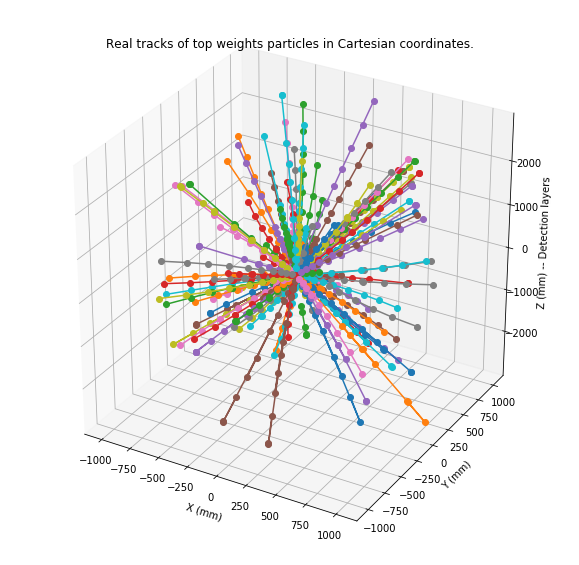

,tx,ty,tz
21627,30.990400,6.621820,2.68015
29164,69.569801,14.589900,3.10546
29195,71.385201,14.957100,3.12531
35962,113.071999,23.215300,3.60002
42150,168.531006,33.644001,4.20230
72534,255.330994,48.741001,5.06517


In [131]:
from mpl_toolkits.mplot3d import Axes3D

NUM_PARTICLES = 150
truth_dedup = truth.drop_duplicates('particle_id')
truth_sort = truth_dedup.sort_values('weight', ascending=False)
truth_head = truth_sort.head(NUM_PARTICLES)

# Get points where the same particle intersected subsequent layers of the observation material
p_traj_list = []
for _, tr in truth_head.iterrows():
    p_traj = truth[truth.particle_id == tr.particle_id][['tx', 'ty', 'tz']]
    p_traj_list.append(p_traj)
    

# Plot with Cartesian coordinates.
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for p_traj in p_traj_list:
    ax.plot(
        xs=p_traj.tx,
        ys=p_traj.ty,
        zs=p_traj.tz,
        marker='o')
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm) -- Detection layers')
plt.title('Real tracks of top weights particles in Cartesian coordinates.')
    
plt.show()
p_traj_list[10]

In [132]:
#hits.shape[0]==submission.shape[0]
hits['track_id']=submission['track_id']
hits['nhits']=submission.groupby('track_id')['event_id'].transform('count')
sub = hits.sort_values('nhits', axis=0, ascending=False).iloc[:1500]
sub.head(10)

,hit_id,x,y,z,volume_id,layer_id,module_id,x2,y2,z2,track_id,nhits
0,1,-56.113800,-9.557100,-1502.500000,7,2,1,-0.037320,-0.006356,-0.999283,0,4448
43703,43704,144.134995,92.568802,224.507996,8,8,826,0.510400,0.327797,0.795010,0,4448
107145,107146,760.364014,-306.313995,-303.600006,17,2,893,0.869823,-0.350410,-0.347305,0,4448
90642,90643,-665.317017,-2.224520,-411.399994,13,8,714,-0.850526,-0.002844,-0.525925,0,4448
90641,90642,-658.546997,34.807598,-376.085999,13,8,714,-0.867459,0.045850,-0.495392,0,4448
43696,43697,159.951996,63.090302,267.303009,8,8,824,0.503263,0.198503,0.841025,0,4448
43695,43696,162.410004,58.617802,261.303009,8,8,824,0.518556,0.187160,0.834309,0,4448
68918,68919,-396.790985,149.505997,-1224.500000,12,12,160,-0.306204,0.115374,-0.944949,0,4448
107186,107187,676.866028,458.829010,-292.799988,17,2,912,0.779293,0.528262,-0.337108,0,4448
68954,68955,-299.113007,55.463100,-1218.500000,12,12,165,-0.238166,0.044162,-0.970220,0,4448


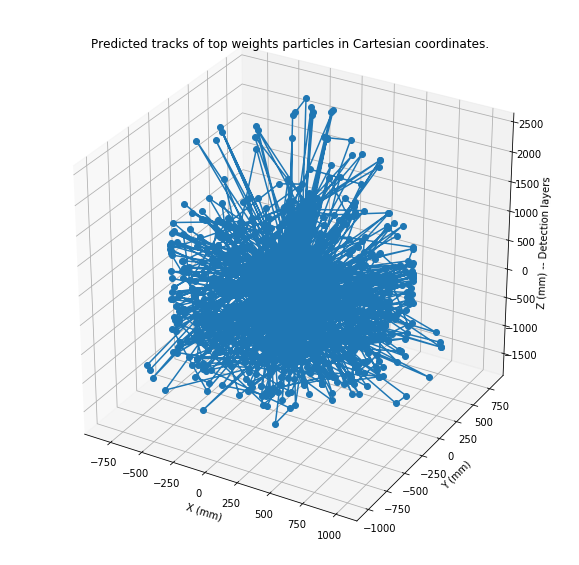

In [133]:
#Plot the predicted tracks
pred_traj_list = []

for track in sub.track_id.unique():
  #print(sub[sub['track_id'] == track]['hit_id'])
  pred_traj_list.append(sub[sub['track_id'] == track][['x', 'y', 'z']]) 
   

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for p_traj in pred_traj_list:
    ax.plot(
        xs=p_traj.x,
        ys=p_traj.y,
        zs=p_traj.z,
        marker='o')
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm) -- Detection layers')
plt.title('Predicted tracks of top weights particles in Cartesian coordinates.')    

plt.show()

In [134]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

class DBSCANClusterer(object):
    
    def __init__(self, eps):
        self.eps = eps
        
    
    def _preprocess(self, hits):
        
        x = hits.x.values
        y = hits.y.values
        z = hits.z.values

        r = np.sqrt(x**2 + y**2 + z**2)
        hits['x2'] = x/r
        hits['y2'] = y/r

        r = np.sqrt(x**2 + y**2)
        hits['z2'] = z/r

        ss = StandardScaler()
        X = ss.fit_transform(hits[['x2', 'y2', 'z2']].values)
        
        return X
    
    
    def predict(self, hits):
        
        X = self._preprocess(hits)
        
        cl = DBSCAN(eps=self.eps, min_samples=1, algorithm='kd_tree')
        labels = cl.fit_predict(X)
        
        return labels
    
model = DBSCANClusterer(eps=0.008)
labels = model.predict(hits)
submission = create_one_event_submission(0, hits, labels)
score = score_event(truth, submission)
print("Your score: ", score)

Your score:  0.1968633799


In [135]:
hits['track_id']=submission['track_id']
hits['nhits']=submission.groupby('track_id')['event_id'].transform('count')
sub = hits.sort_values('nhits', axis=0, ascending=False).iloc[:1500]
sub.head(10)

,hit_id,x,y,z,volume_id,layer_id,module_id,x2,y2,z2,track_id,nhits
50801,50802,-41.102402,14.521400,702.0,9,4,104,-0.058438,0.020646,16.103804,25230,82
61475,61476,-88.229202,29.794901,1502.0,9,14,104,-0.058629,0.019799,16.128986,25230,82
56091,56092,-56.183102,18.969299,958.0,9,8,101,-0.058534,0.019763,16.155407,25230,82
56087,56088,-52.301201,26.724100,958.0,9,8,101,-0.054492,0.027843,16.311037,25230,82
56085,56086,-55.286800,22.602900,958.0,9,8,101,-0.057599,0.023548,16.039181,25230,82
58175,58176,-63.363899,26.327400,1098.0,9,10,101,-0.057596,0.023931,16.002167,25230,82
58191,58192,-64.807999,21.188900,1098.0,9,10,101,-0.058910,0.019261,16.103504,25230,82
59966,59967,-70.482498,37.069199,1298.0,9,12,101,-0.054199,0.028505,16.299141,25230,82
58194,58195,-63.814098,21.859600,1098.0,9,10,101,-0.058009,0.019871,16.277689,25230,82
58195,58196,-64.451202,21.203400,1098.0,9,10,101,-0.058587,0.019274,16.182898,25230,82


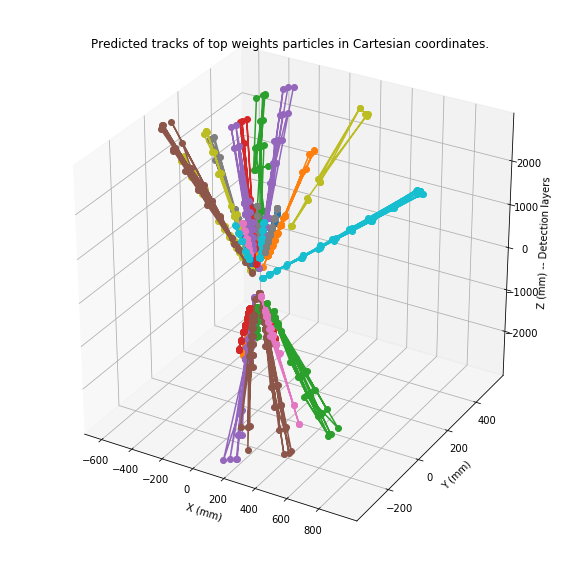

In [136]:
#Plot the predicted tracks
pred_traj_list = []

for track in sub.track_id.unique():
  #print(sub[sub['track_id'] == track]['hit_id'])
  pred_traj_list.append(sub[sub['track_id'] == track][['x', 'y', 'z']]) 
   

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for p_traj in pred_traj_list:
    ax.plot(
        xs=p_traj.x,
        ys=p_traj.y,
        zs=p_traj.z,
        marker='o')
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm) -- Detection layers')
plt.title('Predicted tracks of top weights particles in Cartesian coordinates.')    

plt.show()